## Calcul de l'attention (avec numpy)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = Q @ K.T / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = weights @ V
    return output

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [3]:
import numpy as np
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt


# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once(x, block_size)
    return time.perf_counter() - start

# ------------------------
# Grille jusqu'à confiance 95%
# ------------------------
def exhaustive_grid_until_confidence(x, block_sizes,
                                     initial_repeats=3,
                                     confidence=0.95,
                                     max_iter=100):
    alpha = 1 - confidence
    block_sizes = sorted(set(block_sizes))
    n_blocks = len(block_sizes)
    results = {b: [] for b in block_sizes}

    # Phase initiale
    print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            time_val = measure_time(x, b)
            results[b].append(time_val)
        med = np.median(results[b])
        print(f"Bloc {b:<4} → médiane init : {med:.5f} s")

    total_tests = initial_repeats * n_blocks

    # Itérations
    for iteration in range(1, max_iter+1):
        print(f"\n🔁 Itération {iteration} : mesure de tous les blocs")
        # Mesurer chaque bloc
        for b in block_sizes:
            time_val = measure_time(x, b)
            results[b].append(time_val)
            print(f" Bloc {b:<4} dernière mesure : {time_val:.5f} s, essais : {len(results[b])}")
        total_tests += n_blocks

        # Statistiques par bloc
        means = {b: np.mean(results[b]) for b in block_sizes}
        vars_ = {b: np.var(results[b], ddof=1) for b in block_sizes}
        ns = {b: len(results[b]) for b in block_sizes}

        # Sélection du meilleur moyen actuel
        best = min(means, key=means.get)
        print(f" Meilleur moyen actuel : Bloc {best} (mean={means[best]:.5f})")

        # Test de confiance pair à pair
        all_confident = True
        for b in block_sizes:
            if b == best: 
                continue
            diff = means[b] - means[best]
            var_diff = vars_[b]/ns[b] + vars_[best]/ns[best]
            t_stat = diff / math.sqrt(var_diff)
            # Degrés de liberté Welch-Satterthwaite
            df = (var_diff**2) / ((vars_[b]**2)/(ns[b]**2*(ns[b]-1)) +
                                  (vars_[best]**2)/(ns[best]**2*(ns[best]-1)))
            p_value = 1 - student_t.cdf(t_stat, df)
            print(f"  -> Bloc {best} vs Bloc {b}: p={p_value:.4f}")
            if p_value >= alpha:
                all_confident = False

        if all_confident:
            print("\n✅ Confiance 95% atteinte pour le meilleur bloc.")
            break

    print(f"\n✅ Résultat final : Bloc {best}, tests totaux = {total_tests}")
    return best, results, total_tests


In [4]:
# ------------------------
# Exécution test
# ------------------------
if __name__ == "__main__":
    seq_len, d_model = 1024, 64
    x = np.random.randn(seq_len, d_model)
    blocks = range(64, 1024, 32) # Taille de bloc à tester

    best, results, total_tests = exhaustive_grid_until_confidence(
        x, blocks, initial_repeats=3, confidence=0.95, max_iter=10
    )

🔍 Phase 1 : mesures initiales
Bloc 64   → médiane init : 0.00203 s
Bloc 96   → médiane init : 0.00136 s
Bloc 128  → médiane init : 0.00188 s
Bloc 160  → médiane init : 0.00184 s
Bloc 192  → médiane init : 0.00147 s
Bloc 224  → médiane init : 0.00303 s
Bloc 256  → médiane init : 0.00284 s
Bloc 288  → médiane init : 0.00428 s
Bloc 320  → médiane init : 0.00269 s
Bloc 352  → médiane init : 0.00319 s
Bloc 384  → médiane init : 0.00653 s
Bloc 416  → médiane init : 0.00336 s
Bloc 448  → médiane init : 0.00439 s
Bloc 480  → médiane init : 0.00537 s
Bloc 512  → médiane init : 0.01103 s
Bloc 544  → médiane init : 0.00535 s
Bloc 576  → médiane init : 0.00725 s
Bloc 608  → médiane init : 0.01164 s
Bloc 640  → médiane init : 0.00514 s
Bloc 672  → médiane init : 0.01355 s
Bloc 704  → médiane init : 0.01040 s
Bloc 736  → médiane init : 0.02086 s
Bloc 768  → médiane init : 0.01543 s
Bloc 800  → médiane init : 0.01493 s
Bloc 832  → médiane init : 0.00953 s
Bloc 864  → médiane init : 0.01652 s
Bloc 896

# Benchmark intelligent 1

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm
from scipy.stats import t as student_t


In [6]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = Q @ K.T / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = weights @ V
    return output

# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once(x, block_size)
    return time.perf_counter() - start

In [7]:
# -*- coding: utf-8 -*-
"""
Benchmark adaptatif « jusqu’à confiance ».

◾ `measure_time(x, block)` doit mesurer et renvoyer le temps d’exécution (en secondes)
   pour la taille de bloc demandée.
◾ `run_attention_once(x, block)` exécute la même opération sans rien mesurer
   (run « à blanc » pour chauffer caches, GPU, etc.).

Ces deux fonctions dépendent de ton application et doivent être définies ailleurs.
"""

from math import sqrt
import numpy as np
from scipy.stats import t as student_t


def smart_benchmark_until_confidence(
    x,
    block_sizes,
    *,
    confidence: float = 0.90,
    initial_repeats: int = 1,
    extra_repeats_best: int = 5,
    max_iter: int = 1_000,
    free_runs: int = 5,
    verbose: bool = True,
):
    """
    Recherche itérative du bloc le plus rapide jusqu’à atteindre
    une confiance `confidence` (95 % par défaut).

    Étapes
    ------
    1. `free_runs` passes à blanc sur chaque taille pour chauffer.
    2. `initial_repeats` premières mesures sur tous les blocs.
    3. On répète `extra_repeats_best` fois le bloc le plus prometteur
       pour serrer son intervalle de confiance (IC).
    4. Boucle :
       a) On calcule l’IC supérieur du best courant.
       b) Candidats = blocs dont la moyenne actuelle ≤ IC_sup.
       c) On mesure UNE fois chaque candidat.
       d) Nouveau best = bloc à plus petite moyenne parmi candidats.
       e) Test de Welch : pour chaque bloc, on construit l’IC
          (one-sided) de la différence de moyennes.
          Si, pour **tous** les blocs, l’IC est strictement ≤ 0
          ⇒ on est confiant et on s’arrête.
    """
    # ------------------------------------------------------------------
    # Préparation
    # ------------------------------------------------------------------
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []               # (iter, best, mean, std, ci_up)
    best_blocks_by_iter = []   # suivi de l’ID du best à chaque tour

    # Réchauffe-caches
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once(x, b)

    # Mesures initiales
    if verbose:
        print("🔍 Phase 1 : évaluation initiale")
    for b in block_sizes:
        for _ in range(initial_repeats):
            t = measure_time(x, b)
            results[b].append(t)
        if verbose:
            print(f"Bloc {b:<4} → {np.mean(results[b]):.5f} s "
                  f"(n={len(results[b])})")

    # Best initial + sur-échantillonnage
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose:
        print(f"\nBest initial : {best}")
    for _ in range(extra_repeats_best):
        results[best].append(measure_time(x, best))

    # ------------------------------------------------------------------
    # Boucle principale
    # ------------------------------------------------------------------
    for it in range(1, max_iter + 1):
        # --- stats du best courant ------------------------------------
        times_best = np.asarray(results[best])
        n_best = len(times_best)
        m_best = times_best.mean()
        s_best = times_best.std(ddof=1) if n_best > 1 else 0.0
        t_crit_best = (
            student_t.ppf(1 - (1 - confidence) / 2, df=n_best - 1)
            if n_best > 1 else np.inf
        )
        ci_up_best = m_best + t_crit_best * (s_best / sqrt(n_best))

        history.append((it, best, m_best, s_best, ci_up_best))
        best_blocks_by_iter.append(best)

        if verbose:
            print(f"\n🔁 Itération {it}: "
                  f"Best={best}, mean={m_best:.5f}, σ={s_best:.5f}, "
                  f"CI_sup={ci_up_best:.5f}")

        # --- Sélection des candidats ----------------------------------
        candidates = [
            b for b in block_sizes
            if np.mean(results[b]) <= ci_up_best or b == best
        ]
        if verbose:
            print("Candidats :", candidates)

        # --- Une mesure de plus pour chaque candidat ------------------
        for b in candidates:
            t_b = measure_time(x, b)
            results[b].append(t_b)
            if verbose:
                print(f"  Bloc {b:<4} → {t_b:.5f} s (n={len(results[b])})")

        # --- Nouveau best parmi les candidats -------------------------
        best = min(candidates, key=lambda b: np.mean(results[b]))

        # --- Statistiques MAJ pour le nouveau best --------------------
        times_best = np.asarray(results[best])
        n_best = len(times_best)
        m_best = times_best.mean()
        s_best = times_best.std(ddof=1) if n_best > 1 else 0.0

        # --- Test de confiance vs tous les autres ---------------------
        all_confident = True
        for b in block_sizes:
            if b == best:
                continue

            # stats bloc b
            times_b = np.asarray(results[b])
            n_b = len(times_b)
            m_b = times_b.mean()
            s_b = times_b.std(ddof=1) if n_b > 1 else 0.0

            # variance de la diff Welch
            var_diff = (s_best ** 2) / n_best + (s_b ** 2) / n_b
            if var_diff == 0:          # toutes mesures identiques
                continue

            diff = m_b - m_best        # >0 si b plus lent
            t_stat = diff / sqrt(var_diff)

            # ddl Welch–Satterthwaite
            if n_best > 1 and n_b > 1:
                df = (
                    var_diff ** 2 /
                    (((s_best ** 4) / (n_best ** 2 * (n_best - 1))) +
                     ((s_b ** 4) / (n_b ** 2 * (n_b - 1))))
                )
            else:  # cas limite
                df = n_best + n_b - 2

            # borne supérieure (one-sided) de diff
            t_crit = student_t.ppf(confidence, df)
            ci_up_diff = diff - t_crit * sqrt(var_diff)

            # log
            if verbose:
                p_one_sided = 1 - student_t.cdf(t_stat, df)  # P(best < b)
                print(f"  P({best} < {b}) = {p_one_sided:.3f}")

            # si l'IC inclut encore des valeurs >0 → pas assez sûr
            if ci_up_diff > 0:
                all_confident = False

        if all_confident:
            if verbose:
                print("\n✅ Confiance atteinte pour le best.")
            break

    # ------------------------------------------------------------------
    # Résumé final
    # ------------------------------------------------------------------
    if verbose:
        final_median = float(np.median(results[best]))
        print(f"\n✅ Meilleure taille de bloc : {best} "
              f"({final_median:.5f} s)")
        print("🧮 Nombre total de mesures :", sum(len(v) for v in results.values()))

    return best, results, history, best_blocks_by_iter


🔍 Phase 1 : évaluation initiale
Bloc 64   → 0.00233 s (n=1)
Bloc 96   → 0.00442 s (n=1)
Bloc 128  → 0.00331 s (n=1)
Bloc 160  → 0.00229 s (n=1)
Bloc 192  → 0.00186 s (n=1)
Bloc 224  → 0.00191 s (n=1)
Bloc 256  → 0.00228 s (n=1)
Bloc 288  → 0.00297 s (n=1)
Bloc 320  → 0.00500 s (n=1)
Bloc 352  → 0.00602 s (n=1)
Bloc 384  → 0.00368 s (n=1)
Bloc 416  → 0.00286 s (n=1)
Bloc 448  → 0.00378 s (n=1)
Bloc 480  → 0.00388 s (n=1)
Bloc 512  → 0.00488 s (n=1)
Bloc 544  → 0.00487 s (n=1)
Bloc 576  → 0.00645 s (n=1)
Bloc 608  → 0.00416 s (n=1)
Bloc 640  → 0.00598 s (n=1)
Bloc 672  → 0.00854 s (n=1)
Bloc 704  → 0.00545 s (n=1)
Bloc 736  → 0.00489 s (n=1)
Bloc 768  → 0.00602 s (n=1)
Bloc 800  → 0.00551 s (n=1)
Bloc 832  → 0.00590 s (n=1)
Bloc 864  → 0.00624 s (n=1)
Bloc 896  → 0.00802 s (n=1)
Bloc 928  → 0.01253 s (n=1)
Bloc 960  → 0.00788 s (n=1)
Bloc 992  → 0.01954 s (n=1)

Best initial : 192

🔁 Itération 1: Best=192, mean=0.00469, σ=0.00527, CI_sup=0.00903
Candidats : [64, 96, 128, 160, 192, 224, 2

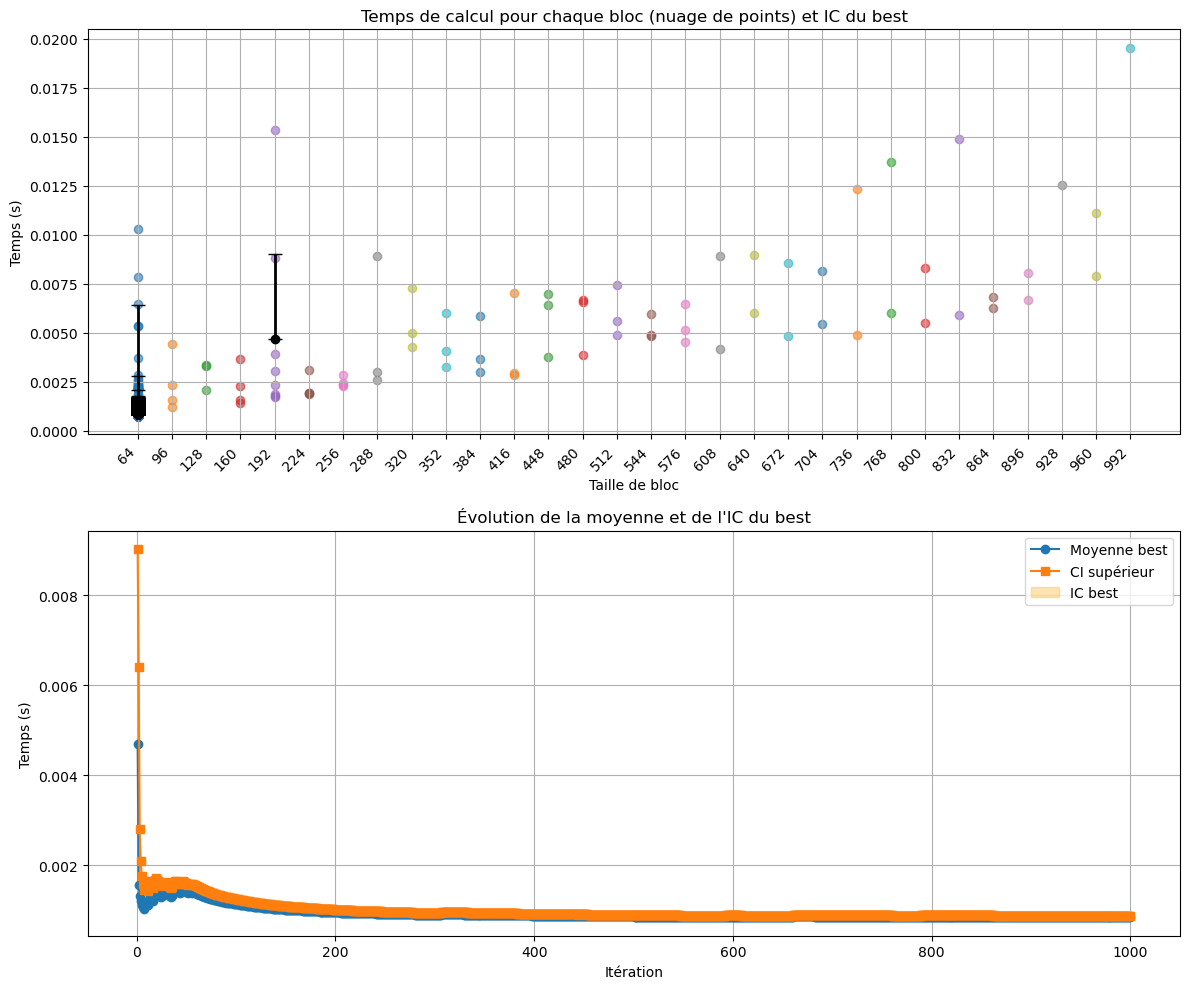

In [8]:
# ------------------------
# Exécution et double graphique
# ------------------------
if __name__ == "__main__":
    seq_len, d_model = 1024, 64
    x = np.random.randn(seq_len, d_model)
    blocks = range(64, 1024, 32) # Taille de bloc à tester
    best, results, hist, best_blocks_by_iter = smart_benchmark_until_confidence(x, blocks)

    # Tracé
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # --- HAUT : nuage de points de tous les temps + IC best par itération ---
    # On positionne chaque point selon son bloc (axe x=bloc, axe y=temps)
    for b in blocks:
        y = results[b]
        x_b = [b] * len(y)
        axes[0].scatter(x_b, y, label=f"Bloc {b}", alpha=0.6)
    # Ajout de l'évolution de l'IC du bloc best
    ic_means = []
    ic_uppers = []
    ic_locs = []
    for i, (iteration, bestb, m, s, ci_upper) in enumerate(hist):
        ic_means.append(m)
        ic_uppers.append(ci_upper)
        ic_locs.append(bestb)
        axes[0].errorbar(bestb, m, yerr=[[0], [ci_upper - m]], fmt='o', color='black', capsize=5, lw=2, label='IC best' if i==0 else "")

    # On force les graduations de l'axe x sur les blocs testés
    axes[0].set_xticks(list(blocks))
    axes[0].set_xticklabels([str(b) for b in blocks], rotation=45, ha="right")
    
    axes[0].set_title("Temps de calcul pour chaque bloc (nuage de points) et IC du best")
    axes[0].set_xlabel("Taille de bloc")
    axes[0].set_ylabel("Temps (s)")
    if len(blocks) < 20:
        axes[0].set_xticks(list(blocks))
        axes[0].legend()
    axes[0].grid(True)

    # --- BAS : évolution de la moyenne et de l'IC du best ---
    iterations = [h[0] for h in hist]
    axes[1].plot(iterations, ic_means, marker='o', label='Moyenne best')
    axes[1].plot(iterations, ic_uppers, marker='s', label='CI supérieur')
    axes[1].fill_between(iterations, ic_means, ic_uppers, color='orange', alpha=0.3, label='IC best')
    axes[1].set_xlabel("Itération")
    axes[1].set_ylabel("Temps (s)")
    axes[1].set_title("Évolution de la moyenne et de l'IC du best")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Benchmark intelligent 2


In [9]:
# -*- coding: utf-8 -*-
"""
Benchmark adaptatif jusqu'à décision probabiliste.

Vous devez fournir deux fonctions adaptées à votre code :
    • measure_time(x, block)   -> float (temps en secondes)
    • run_attention_once(x, b) -> None   (exécution « à blanc »)

Logique :
---------
À chaque itération, pour chaque bloc b ≠ best on calcule
    p_better = P( temps(b) < temps(best) )

    • Si max(p_better) > 0.50  →  on bascule le best sur le bloc qui
      possède cette proba maximale.
    • Si max(p_better) < 0.05  →  on est sûr à 95 % que ‘best’ est le
      plus rapide et on s’arrête.
    • Sinon on continue, en remesurant :
         – toujours le ‘best’,
         – tous les blocs dont p_better ≥ 0.05
"""

from math import sqrt
import numpy as np
from scipy.stats import t as student_t


def _prob_b_faster_than_a(mean_a, std_a, n_a, mean_b, std_b, n_b):
    """
    P(µ_b < µ_a) avec test de Welch sur la différence de moyennes.
    """
    # variance de la différence
    var = (std_a ** 2) / n_a + (std_b ** 2) / n_b
    if var == 0:
        return 0.5          # mesures identiques, probabilité 0.5

    se = sqrt(var)
    diff = mean_b - mean_a             # <0 si b plus rapide
    t_stat = diff / se                 # statistique observée

    # ddl Welch–Satterthwaite
    df = (
        var ** 2 /
        (((std_a ** 4) / (n_a ** 2 * (n_a - 1))) +
         ((std_b ** 4) / (n_b ** 2 * (n_b - 1))))
    )

    # P(diff < 0) = CDF(-|t|)
    p = student_t.cdf(-t_stat, df)
    return p


def smart_benchmark_probabilistic(
    x,
    block_sizes,
    *,
    p_switch: float = 0.50,
    p_stop: float = 0.05,
    initial_repeats: int = 2,
    free_runs: int = 5,
    extra_repeats_best: int = 3,
    max_iter: int = 1_000,
    verbose: bool = True,
):
    # ---------------------------------------------------------------
    # Préparation
    # ---------------------------------------------------------------
    block_sizes = sorted(set(block_sizes))
    results = {b: [] for b in block_sizes}
    history = []          # [ (iter, best, {b: p_better}) ]
    best_track = []       # suivi du best

    # (1) réchauffe-caches
    for _ in range(free_runs):
        for b in block_sizes:
            run_attention_once(x, b)

    # (2) mesures initiales
    if verbose:
        print("🔍 Phase 1 : mesures initiales")
    for b in block_sizes:
        for _ in range(initial_repeats):
            results[b].append(measure_time(x, b))
        if verbose:
            m = np.mean(results[b])
            print(f"Bloc {b:<4} → {m:.5f} s (n={len(results[b])})")

    # (3) best initial + répétitions bonus
    best = min(block_sizes, key=lambda b: np.mean(results[b]))
    if verbose:
        print(f"\nBest initial : {best}")
    for _ in range(extra_repeats_best):
        results[best].append(measure_time(x, best))

    # ---------------------------------------------------------------
    # Boucle principale
    # ---------------------------------------------------------------
    for it in range(1, max_iter + 1):
        # Stats de tous les blocs
        stats = {
            b: (
                np.mean(results[b]),
                np.std(results[b], ddof=1) if len(results[b]) > 1 else 0.0,
                len(results[b]),
            )
            for b in block_sizes
        }
        mean_best, std_best, n_best = stats[best]

        # Probabilités P(b < best)
        p_better = {}
        for b in block_sizes:
            if b == best:
                continue
            mean_b, std_b, n_b = stats[b]
            p = _prob_b_faster_than_a(
                mean_best, std_best, n_best,
                mean_b, std_b, n_b
            )
            p_better[b] = p

        history.append((it, best, p_better.copy()))
        best_track.append(best)

        if verbose:
            print(f"\n🔁 Itération {it}: best = {best}")
            for b, p in sorted(p_better.items()):
                print(f"  P({b} plus rapide que {best}) = {p:.3f}")

        # -----------------------------------------------------------
        # Décision : stop ? switch ?
        # -----------------------------------------------------------
        max_p = max(p_better.values(), default=0.0)
        if max_p < p_stop:
            if verbose:
                print("\n✅ Condition d’arrêt : toutes les probabilités "
                      f"< {p_stop:.2f}.")
            break

        # bloc candidat pour switch (plus forte proba > 0.50)
        if max_p > p_switch:
            new_best = max(p_better, key=p_better.get)
            if verbose:
                print(f"↪️ Switch du best : {best} → {new_best} "
                      f"(p = {max_p:.3f})")
            best = new_best
            # mettre à jour stats best
            mean_best, std_best, n_best = stats[best]

        # -----------------------------------------------------------
        # Sélection des blocs à remesurer
        #   – toujours le best
        #   – tous ceux avec p_better ≥ p_stop
        # -----------------------------------------------------------
        to_measure = [best] + [
            b for b, p in p_better.items() if p >= p_stop
        ]
        if verbose:
            print("Mesures supplémentaires :", to_measure)

        for b in to_measure:
            t = measure_time(x, b)
            results[b].append(t)
            if verbose:
                print(f"  Bloc {b:<4} → {t:.5f} s (n={len(results[b])})")

    # ---------------------------------------------------------------
    # Résultat final
    # ---------------------------------------------------------------
    if verbose:
        m_final = float(np.median(results[best]))
        tot = sum(len(v) for v in results.values())
        print(f"\n🏁 Best final : {best} (médiane = {m_final:.5f} s)")
        print("Mesures totales :", tot)

    return best, results, history, best_track


In [11]:
# ------------------------
# Exécution et double graphique
# ------------------------
if __name__ == "__main__":
    seq_len, d_model = 1024, 64
    x = np.random.randn(seq_len, d_model)
    blocks = range(64, 1024, 32) # Taille de bloc à tester
    best, results, hist, best_blocks_by_iter = smart_benchmark_probabilistic(x, blocks)

🔍 Phase 1 : mesures initiales
Bloc 64   → 0.00288 s (n=2)
Bloc 96   → 0.00279 s (n=2)
Bloc 128  → 0.00513 s (n=2)
Bloc 160  → 0.00342 s (n=2)
Bloc 192  → 0.00420 s (n=2)
Bloc 224  → 0.00593 s (n=2)
Bloc 256  → 0.00358 s (n=2)
Bloc 288  → 0.00862 s (n=2)
Bloc 320  → 0.00586 s (n=2)
Bloc 352  → 0.00346 s (n=2)
Bloc 384  → 0.01388 s (n=2)
Bloc 416  → 0.00942 s (n=2)
Bloc 448  → 0.00576 s (n=2)
Bloc 480  → 0.00755 s (n=2)
Bloc 512  → 0.00794 s (n=2)
Bloc 544  → 0.00874 s (n=2)
Bloc 576  → 0.00766 s (n=2)
Bloc 608  → 0.01541 s (n=2)
Bloc 640  → 0.00731 s (n=2)
Bloc 672  → 0.00940 s (n=2)
Bloc 704  → 0.01188 s (n=2)
Bloc 736  → 0.01470 s (n=2)
Bloc 768  → 0.01210 s (n=2)
Bloc 800  → 0.01041 s (n=2)
Bloc 832  → 0.01033 s (n=2)
Bloc 864  → 0.01060 s (n=2)
Bloc 896  → 0.01282 s (n=2)
Bloc 928  → 0.01032 s (n=2)
Bloc 960  → 0.01458 s (n=2)
Bloc 992  → 0.01140 s (n=2)

Best initial : 96

🔁 Itération 1: best = 96
  P(64 plus rapide que 96) = 0.629
  P(128 plus rapide que 96) = 0.233
  P(160 plus r